In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brent
from sympy import symbols, Poly, div, diff, lambdify

# Finding roots in 1-D

### Plotting the LHS and RHS

$ tan(x) = \sqrt{\pi\alpha-x}$

In [2]:
def func_lhs(x):
    return np.tan(x)

def func_rhs(alpha, x):
    return np.sqrt(np.pi*alpha - x)

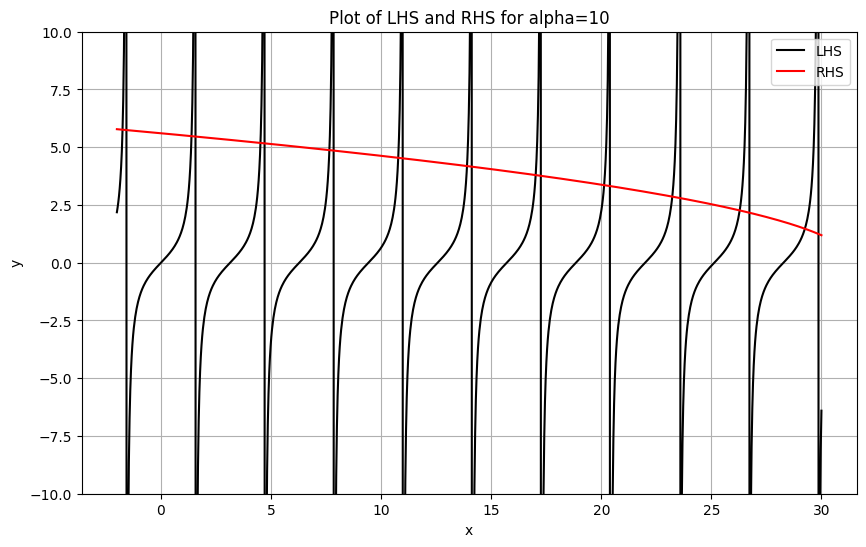

In [3]:
alpha = 10
xx = np.linspace(-2,30,1000)
yy_lhs = func_lhs(xx)
yy_rhs = func_rhs(alpha, xx)

plt.figure(figsize=(10,6))
plt.plot(xx,yy_lhs,color='black')
plt.plot(xx,yy_rhs,color='red')
plt.legend(['LHS','RHS'])
plt.ylim([-10,10])
plt.grid('both')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Plot of LHS and RHS for alpha={alpha}')
plt.show()

### Bracketing the roots

In [4]:
def func(alpha, x):
    return np.tan(x) - np.sqrt(np.pi*alpha - x)

Bracketed regions are $[n\pi,(n+\dfrac{1}{2})\pi)$

In [5]:
brac_pts = np.array([[i*np.pi,(i+0.5)*np.pi-1e-13] for i in range(int(alpha))])

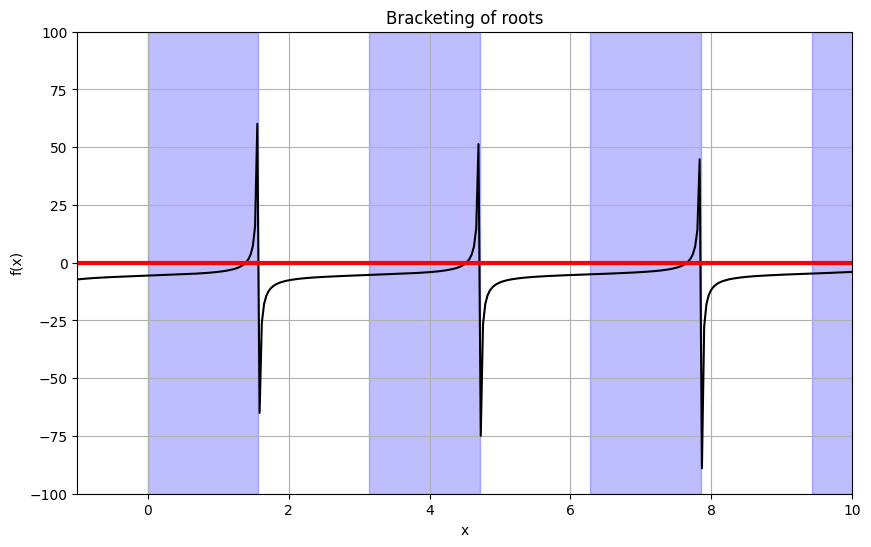

In [6]:
plt.figure(figsize=(10,6))
plt.plot(xx,func(10,xx),color='black')
plt.axhline(0,color='red',lw=3)
for i in range(len(brac_pts)):
    plt.axvspan(brac_pts[i,0],brac_pts[i,1], color='blue', alpha=0.26)
plt.ylim([-100,100])
plt.xlim([-1,10])
plt.grid('both')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Bracketing of roots')
plt.show()

### Using Bisection, Secant, Brent and Newton-Ralphson to find the roots

In [7]:
def bisection(func, a, b, tol, n):
    assert func(a)*func(b) < 0
    c = (a+b)/2
    n = n+1
    if func(c) == 0 or (b-a) < tol:
        return (c,n)
    elif (func(a)*func(c) < 0):
        return bisection(func, a, c, tol, n)
    else:
        return bisection(func, c, b, tol, n)

#### Bug in secant

In [20]:
def secant(func, x1, x2, tol):
    fl,f,n = func(x1), func(x2), 1
    assert fl*f < 0
    if abs(fl) <= abs(f):
        rtsec = x1
        xl = x2
        fl,f = f,fl
    else:
        xl = x1
        rtsec = x2
    while True:
        dx = (xl-rtsec)*f/(f-fl)
        xl = rtsec
        fl = f
        rtsec += dx
        f = func(rtsec)
        n += 1
        if abs(f) <= tol : #abs(dx) <= tol or f==0:
            break
    return rtsec, n

In [10]:
def brent_root(f,x0,x1,tol):
    f0 = f(x0)
    f1 = f(x1)
    assert f0*f1 < 0
    if abs(f0) < abs(f1):
        x0,x1 = x1,x0
        f0,f1 = f1,f0
    x2,f2 = x0,f0
    mflag = True
    n = 0
    while abs(x1-x0) > tol:
        f0 = f(x0)
        f1 = f(x1)
        f2 = f(x2)
        if f0 != f2 and f1 != f2:  # IQI
            l0 = (x0*f1*f2)/((f0-f1)*(f0-f2))
            l1 = (x1*f0*f2)/((f1-f0)*(f1-f2))
            l2 = (x2*f1*f0)/((f2-f0)*(f2-f1))
            new = l0 + l1 + l2
        else:
            new = x1 - ((f1*(x1-x0))/(f1-f0))
        if ((new < ((3*x0 + x1)/4) or new > x1) or
            (mflag == True and (abs(new-x1)) >= (abs(x1-x2)/2)) or
            (mflag == False and (abs(new-x1)) >= (abs(x2-d)/2)) or
            (mflag == True and (abs(x1-x2)) < tol) or
            (mflag == False and (abs(x2-d)) < tol)):
            new = (x0 + x1)/2
            mflag = True
        else:
            mflag = False
        fnew = f(new)
        d,x2 = x2,x1
        if (f0*fnew) < 0:
            x1 = new
        else:
            x0 = new
        if abs(f0) < abs(f1):
            x0,x1 = x1,x0
        n += 1
    return x1, n

In [11]:
f = lambda x : func(alpha,x)

### Side Quest: Complex step differentiation

In [12]:
def deriv_exact(alpha,x):
    return (np.cos(x))**(-2) + 1/(2*np.sqrt(np.pi*alpha-x))

In [13]:
def deriv_for(func,x,h):
    return (func(x+h)-func(x))/h

def deriv_cen(func,x,h):
    return (func(x+h/2)-func(x-h/2))/h

def deriv_comp(func,x,h):
    return func(x+1j*h).imag/h

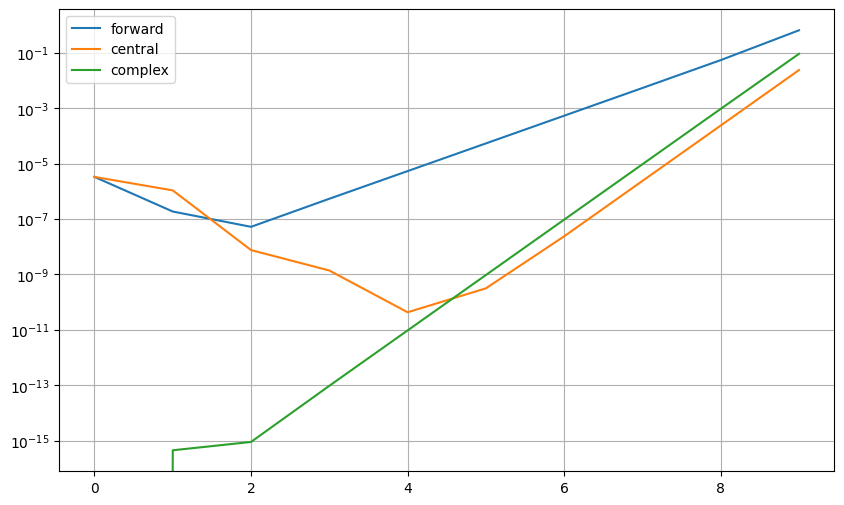

In [14]:
x = 1
for_vals,cen_vals,comp_vals = [],[],[]
for i in range(-10,0):
    h = 10**i
    for_vals.append(np.abs(deriv_for(f,x,h)-deriv_exact(alpha,x)))
    cen_vals.append(np.abs(deriv_cen(f,x,h)-deriv_exact(alpha,x)))
    comp_vals.append(np.abs(deriv_comp(f,x,h)-deriv_exact(alpha,x)))
plt.figure(figsize=(10,6))
plt.semilogy(for_vals)
plt.semilogy(cen_vals)
plt.semilogy(comp_vals)
plt.grid('both')
plt.legend(['forward','central','complex'])
plt.show()

In [15]:
def newton_raphson(f,x,tol):
    n,h = 0,1e-8
    while abs(f(x)) > tol:
        df = deriv_comp(f,x,h)
        x -= f(x)/df
        n += 1
    return x, n

In [16]:
tol = 1e-12

In [17]:
# using bisection

for i in range(len(brac_pts)):
    print(bisection(f,brac_pts[i][0],brac_pts[i][1],tol,0))

(np.float64(1.3902865684448953), 42)
(np.float64(4.521898144224876), 42)
(np.float64(7.651654402614872), 42)
(np.float64(10.778901331884812), 42)
(np.float64(13.902610444879068), 42)
(np.float64(17.021050471241857), 42)
(np.float64(20.13102434219674), 42)
(np.float64(23.22578224480402), 42)
(np.float64(26.287701704750496), 42)
(np.float64(29.248471600013758), 42)


In [24]:
# using secant 

brac_pts_new = np.array([[i*np.pi,(i+0.5)*np.pi-0.15] for i in range(int(alpha))])

for i in range(len(brac_pts)):
    print(secant(f,brac_pts_new[i][0],brac_pts_new[i][1],1e-14))

(np.float64(1.390286568444755), 11)
(np.float64(4.5218981442245685), 11)
(np.float64(7.651654402615209), 12)


/tmp/ipykernel_4616/885871172.py:12: RuntimeWarning: invalid value encountered in scalar divide
  dx = (xl-rtsec)*f/(f-fl)


KeyboardInterrupt: 

In [56]:
# using brent

for i in range(len(brac_pts)):
    print(brent_root(f,brac_pts[i][0],brac_pts[i][1],tol))

(np.float64(1.390286568444753), 23)
(np.float64(4.5218981442245685), 29)
(np.float64(7.6516544026152635), 15)
(np.float64(10.778901331884528), 15)
(np.float64(13.902610444879208), 17)
(np.float64(17.02105047124215), 32)
(np.float64(20.131024342196184), 28)
(np.float64(23.22578224480413), 24)
(np.float64(26.287701704750525), 21)
(np.float64(29.24847160001375), 19)


In [57]:
# using newton-raphson

x =  np.array([(i+0.5)*np.pi-0.15 for i in range(int(alpha))])

for i in range(len(x)):
    print(newton_raphson(f,x[i],tol))

(np.float64(1.390286568444755), 5)
(np.float64(4.5218981442245685), 5)
(np.float64(7.651654402615209), 5)
(np.float64(10.77890133188453), 5)
(np.float64(13.902610444879125), 5)
(np.float64(17.02105047124215), 6)
(np.float64(20.131024342196817), 6)
(np.float64(23.225782244804133), 6)
(np.float64(26.287701704750543), 6)
(np.float64(29.248471600013744), 7)


# Finding multiple roots in 1-D

$f(x) = (x-2+\epsilon)(x-2-\epsilon)(x-2)$ <br>
$f(x) = x^3 -6x^2 + (12-\epsilon^2)x - 8 + 2\epsilon^2$

In [58]:
def generate_sturm_sequence(f, x):
    sturm_sequence = [f, diff(f, x)]
    while True:
        _, remainder = div(sturm_sequence[-2], sturm_sequence[-1], domain='QQ')
        remainder = -remainder
        if remainder.is_zero:
            break
        sturm_sequence.append(remainder)
    return sturm_sequence

def V(sturm_sequence, x_value):
    values = []
    for poly in sturm_sequence:
        func = lambdify((X), poly)
        values.append(func(x_value))
    sign_changes = 0
    for i in range(len(values) - 1):
        if values[i] * values[i + 1] < 0:
            sign_changes += 1
    return sign_changes

In [59]:
X = symbols('X')
eps = 1e-3

f = X**3 - 6*X**2 + (12 - eps**2)*X - 8 + 2*eps**2

sturm_seq = generate_sturm_sequence(f, X)

In [60]:
# No of real roots between -infinity and infinity

V(sturm_seq,-np.inf) - V(sturm_seq,np.inf)

3

In [61]:
# No of real roots between 1 and 3

V(sturm_seq,1) - V(sturm_seq,3)

3

In [62]:
def f(x):
    return (x-2-eps)*(x-2+eps)*(x-2)

In [63]:
# running bisection to zero in on one root
root_1,_ = bisection(f,1,3,1e-15,0)
print("Root 1 : ",root_1)

Root 1 :  2.0


In [64]:
# No of real roots left in region [root_1 + eps(machine precision),3]

V(sturm_seq,root_1+1e-8)-V(sturm_seq,3)

1

Therefore one root remains in the region $(root_1,3]$ <br>
and one root remains in the region $[1,root_1)$

In [65]:
# running bisection to zero in the second root
root_2,_ = bisection(f,root_1+1e-8,3,1e-15,0)
print("Root 2 : ",root_2)

Root 2 :  2.001


In [66]:
# running bisection to zero in on the last root
root_3,_ = bisection(f,1, root_1-1e-8,1e-15,0)
print("Root 3 : ",root_3)

Root 3 :  1.9989999999999997


# Minimization in 1-D

In [67]:
def f(x):
    return np.sin(x) + 1/(1+x**2)

#### Graphing the function

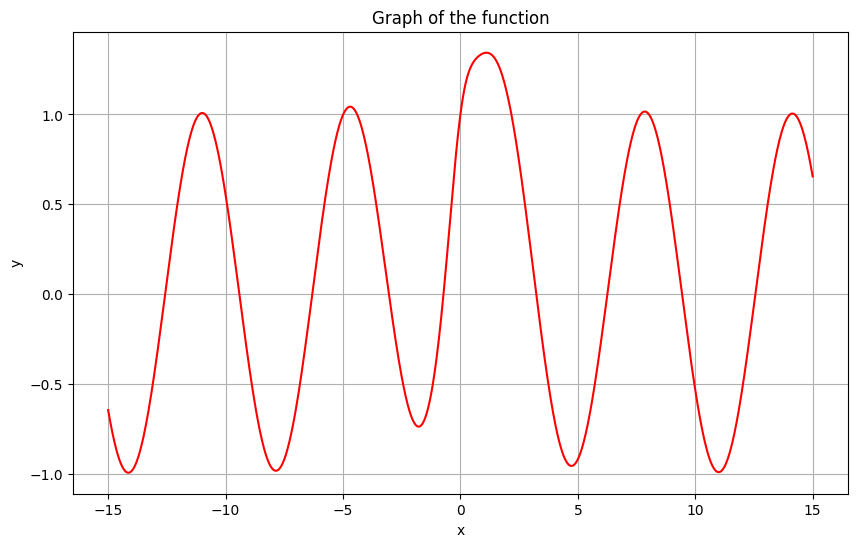

In [68]:
xx = np.linspace(-15,15,1000)
yy = f(xx)
plt.figure(figsize=(10,6))
plt.plot(xx,yy,'red')
plt.grid('both')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graph of the function')
plt.show()

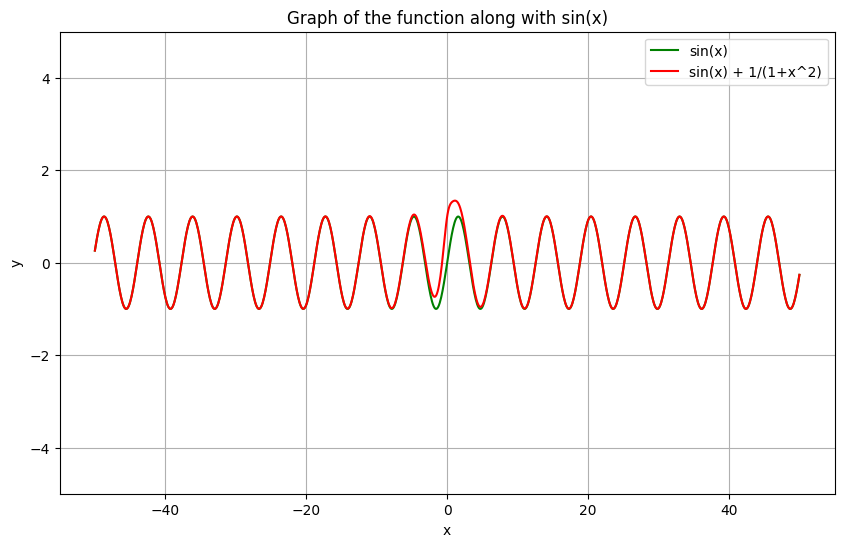

In [69]:
xx = np.linspace(-50,50,1000)
yy = f(xx)
plt.figure(figsize=(10,6))
plt.plot(xx,np.sin(xx),'g',xx,yy,'r')
plt.legend(['sin(x)','sin(x) + 1/(1+x^2)'])
plt.grid('both')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graph of the function along with sin(x)')
plt.ylim([-5,5])
plt.show()

### Bracketing the first 10 positive minima

The bracketed regions are $[n\pi,(n+1)\pi]$ for $n$ $\in \{2i-1, i \in \mathbb{N}\}$ (taking just first ten values)

In [70]:
brac_pts = np.array([[i*np.pi,(i+1)*np.pi] for i in range(1,21,2)])

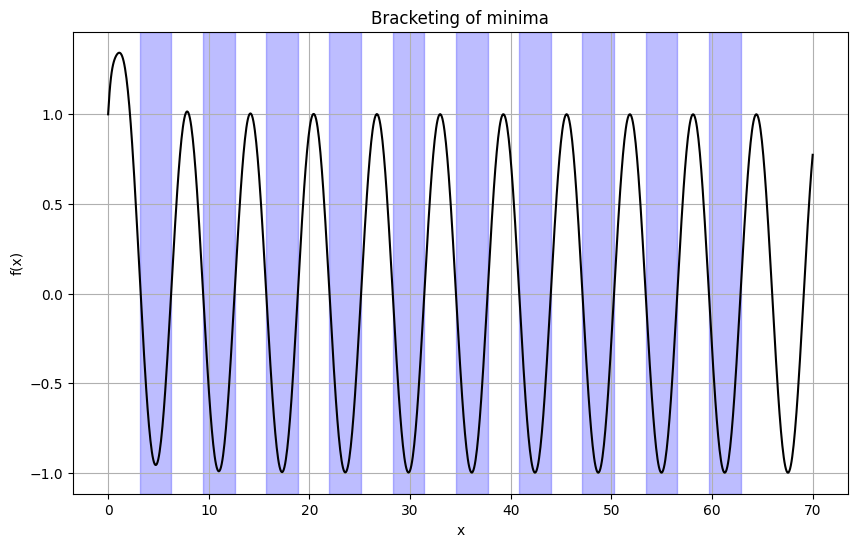

In [71]:
plt.figure(figsize=(10,6))
xx = np.linspace(0,70,1000)
plt.plot(xx,f(xx),color='black')
for i in range(len(brac_pts)):
    plt.axvspan(brac_pts[i,0],brac_pts[i,1], color='blue', alpha=0.26)
plt.grid('both')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Bracketing of minima')
plt.show()

### Using golden section to zero in on the minima

In [72]:
def golden(f,xlower,xupper,tol):
    invphi = (np.sqrt(5)-1)/2
    count = 0
    while (xupper-xlower)>tol:
        x_r1 = xupper - invphi*(xupper-xlower)
        x_r2 = xlower + invphi*(xupper-xlower)
        if f(x_r1) <= f(x_r2):
            xupper = x_r2
            x_r2 = x_r1
            x_r1 = xupper - invphi*(xupper-xlower)
        else:
            xlower = x_r1
            x_r1 = x_r2
            x_r2 = xlower + invphi*(xupper-xlower)
        count += 1
    return (x_r1 + x_r2)/2 , count

In [73]:
tol = 1e-12
for i in range(len(brac_pts)):
    print(golden(f,brac_pts[i][0],brac_pts[i][1],tol))

(np.float64(4.729709570558981), 60)
(np.float64(10.997053555122996), 60)
(np.float64(17.279144673753343), 60)
(np.float64(23.56209723351678), 60)
(np.float64(29.845205258602128), 60)
(np.float64(36.128357849553716), 60)
(np.float64(42.41152701707259), 60)
(np.float64(48.69470342288828), 60)
(np.float64(54.97788345916771), 60)
(np.float64(61.261065433331176), 60)


### Comparing with brent

In [74]:
for i in range(len(brac_pts)):
    val,_,n,_ = brent(f,brack=(brac_pts[i,0],0.5*brac_pts[i,0]+0.5*brac_pts[i,1],brac_pts[i,1]),tol=1e-12,full_output=1)
    print(val,n)

4.729709593793507 22
10.997053560788045 7
17.27914468931676 26
23.562097245917467 24
29.845205270071677 28
36.128357863020746 9
42.411527011752206 19
48.69470343732222 8
54.97788345465801 24
61.2610654394098 11


### Determining the dead zone

In [75]:
x_1,_,_,_ = brent(f,brack=(brac_pts[0,0],0.5*brac_pts[0,0]+0.5*brac_pts[0,1],brac_pts[0,1]),tol=1e-20,full_output=1)
eps = np.finfo(float).eps
print('Value of eps : ' ,eps)
f_val = f(x_1)
for i in np.logspace(1,8):
    if abs(f_val - f(x_1 + i*eps)) > eps:
        x_high_diff = i*eps
        break
        
print('Width of the dead zone region is of the order : ',x_high_diff)

Value of eps :  2.220446049250313e-16
Width of the dead zone region is of the order :  1.5980232093174593e-08


### Differentiating and finding the minima using root finding

$f(x) = \sin(x) + \dfrac{1}{1+x^2}$
$f'(x) = \cos(x) - \dfrac{2x}{(1+x^2)^2}$

In [76]:
def f_p(x):
    return np.cos(x) - (2*x)/(1+x**2)**2

In [77]:
# using bisection
tol = 1e-12
for i in range(len(brac_pts)):
    print(bisection(f_p,brac_pts[i,0],brac_pts[i,1],tol,0))

(np.float64(4.729709586398524), 43)
(np.float64(10.997053560790158), 43)
(np.float64(17.279144681842496), 43)
(np.float64(23.562097245810968), 43)
(np.float64(29.845205273101527), 43)
(np.float64(36.12835786303691), 43)
(np.float64(42.411527011051234), 43)
(np.float64(48.694703437513766), 43)
(np.float64(54.97788346541202), 43)
(np.float64(61.261065439507774), 43)


In [78]:
# using secant
for i in range(len(brac_pts)):
    print(secant(f_p,brac_pts[i,0],brac_pts[i,1],tol))

(np.float64(4.729709586398528), 6)
(np.float64(10.99705356079051), 5)
(np.float64(17.279144681842826), 5)
(np.float64(23.562097245811255), 4)
(np.float64(29.84520527310186), 4)
(np.float64(36.128357863037074), 4)
(np.float64(42.41152701105106), 4)
(np.float64(48.694703437513944), 4)
(np.float64(54.97788346541168), 4)
(np.float64(61.261065439507654), 4)


In [79]:
# using brent
for i in range(len(brac_pts)):
    print(brent_root(f_p,brac_pts[i,0],brac_pts[i,1],tol))

(np.float64(4.729709586398528), 41)
(np.float64(10.99705356079051), 15)
(np.float64(17.279144681842826), 34)
(np.float64(23.562097245811255), 5)
(np.float64(29.845205273101815), 6)
(np.float64(36.12835786303707), 29)
(np.float64(42.41152701105106), 29)
(np.float64(48.694703437513944), 27)
(np.float64(54.97788346541168), 26)
(np.float64(61.261065439507654), 26)


In [80]:
# using newton-raphson
for i in range(len(brac_pts)):
    print(newton_raphson(f_p,0.5*(brac_pts[i,0]+brac_pts[i,1]),tol))

(np.float64(4.7297095863984735), 2)
(np.float64(10.99705356079051), 2)
(np.float64(17.279144681842826), 2)
(np.float64(23.562097245810207), 1)
(np.float64(29.84520527310174), 1)
(np.float64(36.12835786303705), 1)
(np.float64(42.41152701105106), 1)
(np.float64(48.694703437513944), 1)
(np.float64(54.97788346541168), 1)
(np.float64(61.261065439507654), 1)
